# Image Segmentation using ML SegNet Skin-Lesion 

In [1]:
#Importing the Keras Models
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob

#Importing the Image Processing Models

import PIL
import os
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2

#Importing the Machine Learning Models
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [2]:
print(os.listdir('input'))

['trainx', 'trainy']


### Firstly Loading the PH2 dataset

In [3]:
# Defining a function to load the data in sorted order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

* * * First we will load the filenames in a list.  

In [4]:
filelist_trainx_ph2 = sorted(glob.glob('input/trainx/*.bmp'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])
# print(X_train_ph2)

filelist_trainy_ph2 = sorted(glob.glob('input/trainy/*.bmp'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])
# print(Y_train_ph2)

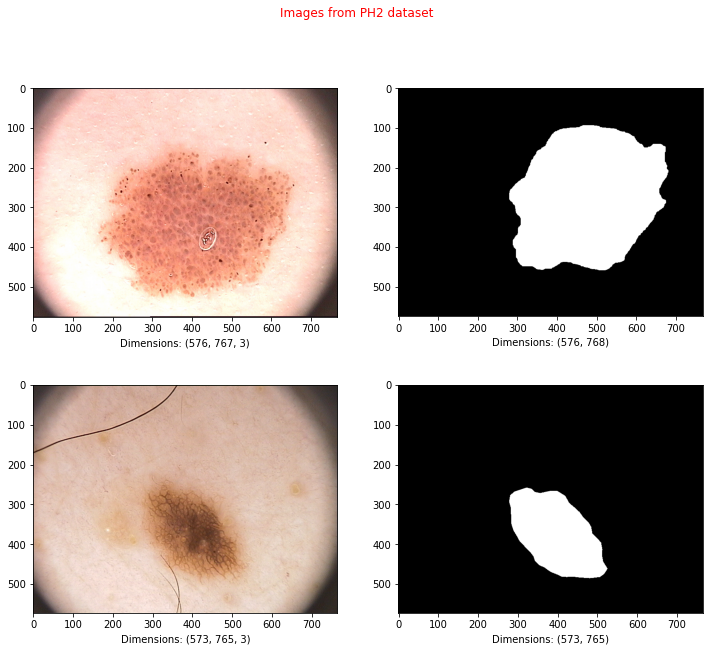

In [8]:
plt.figure(figsize=(12,10))

plt.suptitle('Images from PH2 dataset', fontsize = 12, color='red')
 
plt.subplot(2,2,1)
plt.imshow(X_train_ph2[100])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[100]).shape))
plt.subplot(2,2,2)
plt.imshow(Y_train_ph2[110], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[110]).shape))

plt.subplot(2,2,3)
plt.imshow(X_train_ph2[18])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[18]).shape))
plt.subplot(2,2,4)
plt.imshow(Y_train_ph2[18], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[18]).shape))
plt.show()

#### Resizing the Image from (572, 765) to (256,192), so we will scale down the images. It will also reduce the training time of the network.

In [9]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

In [10]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))    
    

In [11]:
# Converting the transformed Images into numpy arrays

X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

In [12]:
# * Splitting the dataset into training set and test set to verify our model performance without any bias.

x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

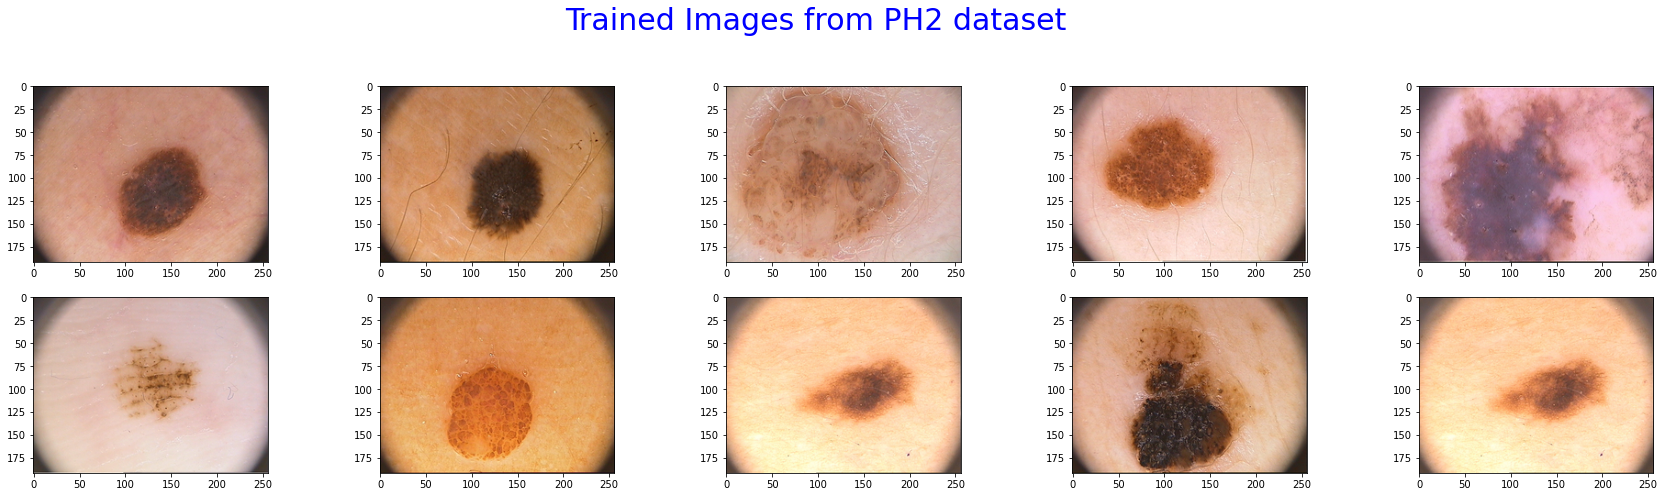

In [15]:
plt.figure(figsize=(30,11))

plt.suptitle('Trained Images from PH2 dataset', fontsize = 30, color='blue')

plt.subplot(3,5,1)
plt.imshow(X_train_ph2[15])
plt.subplot(3,5,2)
plt.imshow(X_train_ph2[95])
plt.subplot(3,5,3)
plt.imshow(X_train_ph2[23])
plt.subplot(3,5,4)
plt.imshow(X_train_ph2[10])
plt.subplot(3,5,5)
plt.imshow(X_train_ph2[184])
plt.subplot(3,5,6)
plt.imshow(X_train_ph2[4])
plt.subplot(3,5,7)
plt.imshow(X_train_ph2[105])
plt.subplot(3,5,8)
plt.imshow(X_train_ph2[195])
plt.subplot(3,5,9)
plt.imshow(X_train_ph2[175])
plt.subplot(3,5,10)
plt.imshow(X_train_ph2[195])

plt.show()

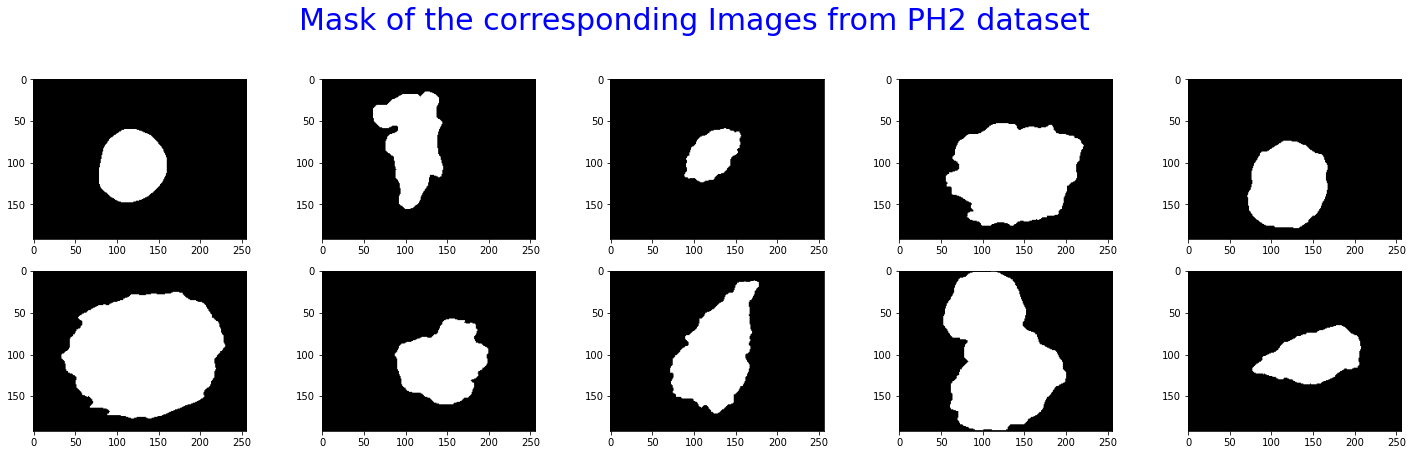

In [16]:
plt.figure(figsize=(25,10))

plt.suptitle('Mask of the corresponding Images from PH2 dataset', fontsize = 30, color='blue')

plt.subplot(3,5,1)
plt.imshow(Y_train_ph2[5], cmap = plt.cm.binary_r)
plt.subplot(3,5,2)
plt.imshow(Y_train_ph2[25], cmap = plt.cm.binary_r)
plt.subplot(3,5,3)
plt.imshow(Y_train_ph2[75], cmap = plt.cm.binary_r)
plt.subplot(3,5,4)
plt.imshow(Y_train_ph2[100], cmap = plt.cm.binary_r)
plt.subplot(3,5,5)
plt.imshow(Y_train_ph2[105], cmap = plt.cm.binary_r)
plt.subplot(3,5,6)
plt.imshow(Y_train_ph2[125], cmap = plt.cm.binary_r)
plt.subplot(3,5,7)
plt.imshow(Y_train_ph2[145], cmap = plt.cm.binary_r)
plt.subplot(3,5,8)
plt.imshow(Y_train_ph2[165], cmap = plt.cm.binary_r)
plt.subplot(3,5,9)
plt.imshow(Y_train_ph2[175], cmap = plt.cm.binary_r)
plt.subplot(3,5,10)
plt.imshow(Y_train_ph2[195], cmap = plt.cm.binary_r)

plt.show()

## Image Augmentation

In [17]:
def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def vertical_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 0)
    y_image = cv2.flip(y_image.astype('float32'), 0)
    return x_image, y_image.astype('int')

def both_flip(x_image, y_image):
    x_image = cv2.flip(x_image, -1)
    y_image = cv2.flip(y_image.astype('float32'), -1)
    return x_image, y_image.astype('int')

def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-60,60)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

In [18]:
def img_augmentation(x_train, y_train):
    x_flip = []
    y_flip = []
    x_vert = []
    y_vert = []
    x_both = []
    y_both = []
    x_rotat = []
    y_rotat = []
    
    for idx in range(len(x_train)):
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
        x,y = vertical_flip(x_train[idx], y_train[idx])
        x_vert.append(x)
        y_vert.append(y)
        
        x,y = both_flip(x_train[idx], y_train[idx])
        x_both.append(x)
        y_both.append(y)
        
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        

        
    return  np.array(x_flip), np.array(y_flip), np.array(x_vert), np.array(y_vert), np.array(x_both), np.array(y_both), np.array(x_rotat), np.array(y_rotat)

calling the functions for the training data.

In [19]:
x_flipped, y_flipped, x_vertical, y_vertical, x_bothed, y_bothed, x_rotated, y_rotated = img_augmentation(x_train, y_train)
x_flipped_t, y_flipped_t, x_vertical_t, y_vertical_t, x_bothed_t, y_bothed_t,  x_rotated_t, y_rotated_t  = img_augmentation(x_test, y_test)

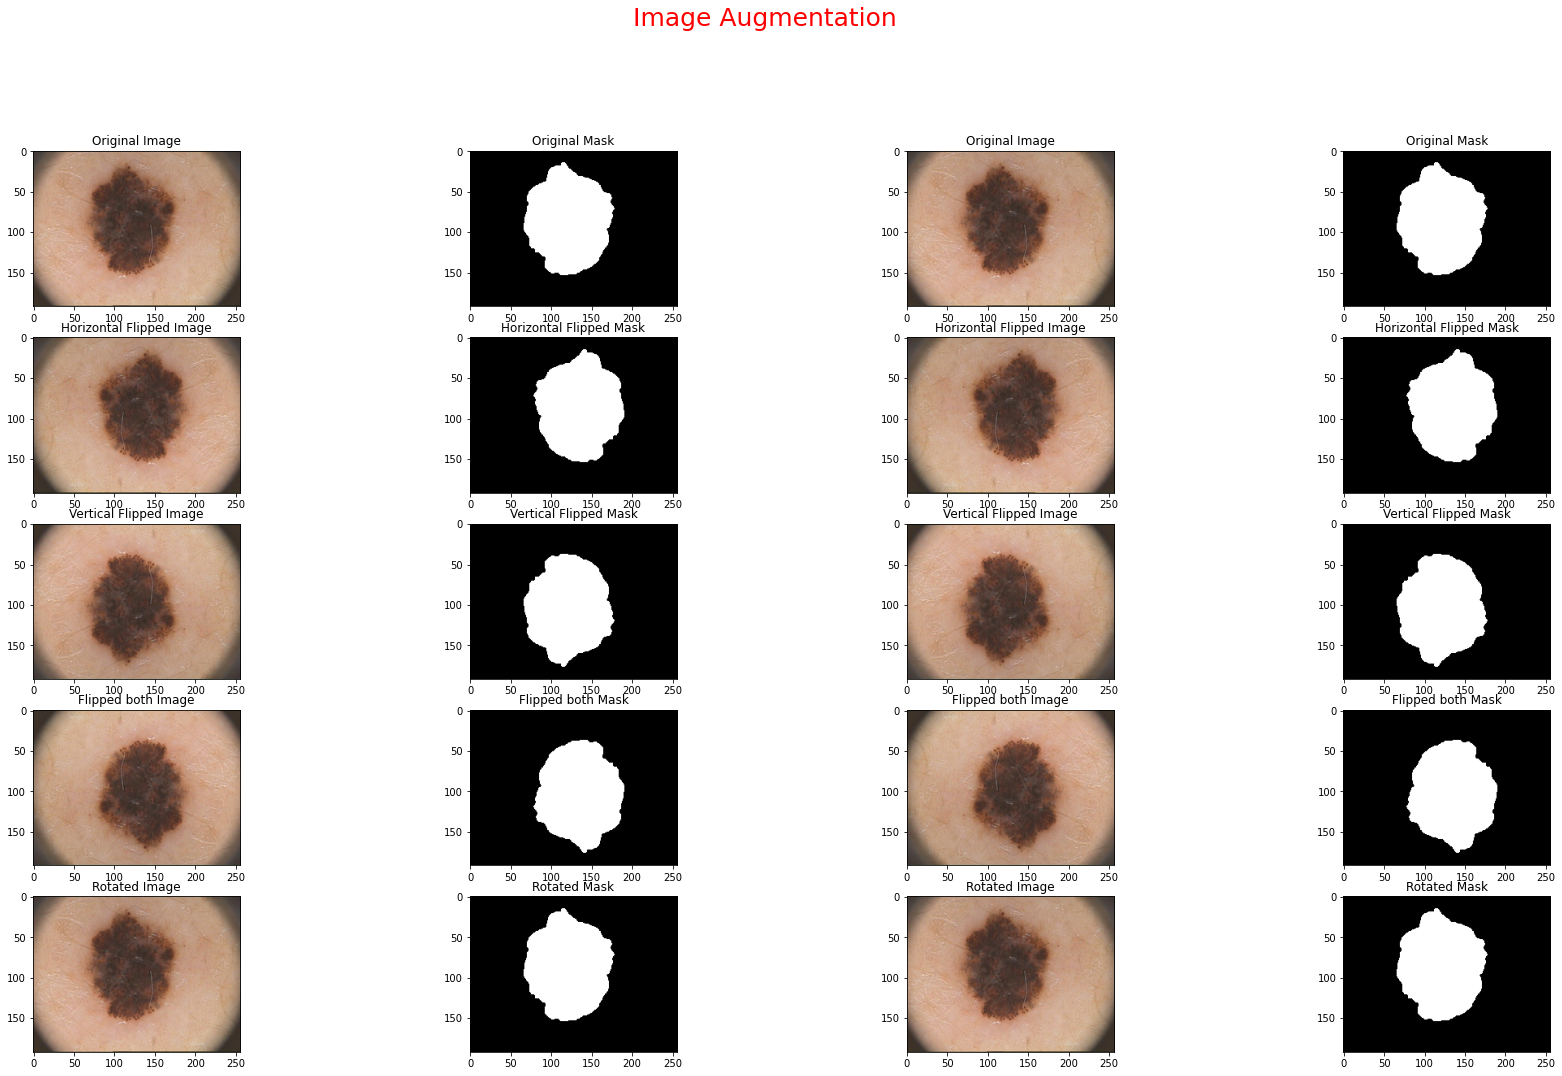

In [22]:
plt.figure(figsize=(30,20))

plt.suptitle('Image Augmentation', fontsize = 25, color='red')

plt.subplot(6,4,1)
plt.imshow(x_train[15])
plt.title('Original Image')
plt.subplot(6,4,2)
plt.imshow(y_train[15], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(6,4,3)
plt.imshow(x_train[15])
plt.title('Original Image')
plt.subplot(6,4,4)
plt.imshow(y_train[15], plt.cm.binary_r)
plt.title('Original Mask')

plt.subplot(6,4,5)
plt.imshow(x_flipped[15])
plt.title('Horizontal Flipped Image')
plt.subplot(6,4,6)
plt.imshow(y_flipped[15], plt.cm.binary_r)
plt.title('Horizontal Flipped Mask')
plt.subplot(6,4,7)
plt.imshow(x_flipped[15])
plt.title('Horizontal Flipped Image')
plt.subplot(6,4,8)
plt.imshow(y_flipped[15], plt.cm.binary_r)
plt.title('Horizontal Flipped Mask')

plt.subplot(6,4,9)
plt.imshow(x_vertical[15])
plt.title('Vertical Flipped Image')
plt.subplot(6,4,10)
plt.imshow(y_vertical[15], plt.cm.binary_r)
plt.title('Vertical Flipped Mask')
plt.subplot(6,4,11)
plt.imshow(x_vertical[15])
plt.title('Vertical Flipped Image')
plt.subplot(6,4,12)
plt.imshow(y_vertical[15], plt.cm.binary_r)
plt.title('Vertical Flipped Mask')

plt.subplot(6,4,13)
plt.imshow(x_bothed[15])
plt.title('Flipped both Image')
plt.subplot(6,4,14)
plt.imshow(y_bothed[15], plt.cm.binary_r)
plt.title('Flipped both Mask')
plt.subplot(6,4,15)
plt.imshow(x_bothed[15])
plt.title('Flipped both Image')
plt.subplot(6,4,16)
plt.imshow(y_bothed[15], plt.cm.binary_r)
plt.title('Flipped both Mask')

plt.subplot(6,4,17)
plt.imshow(x_rotated[15])
plt.title('Rotated Image')
plt.subplot(6,4,18)
plt.imshow(y_rotated[15], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(6,4,19)
plt.imshow(x_rotated[15])
plt.title('Rotated Image')
plt.subplot(6,4,20)
plt.imshow(y_rotated[15], plt.cm.binary_r)
plt.title('Rotated Mask')

plt.show()


Now we join all the augmentations image arrays to the original training arrays.

In [23]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped, x_bothed, x_vertical])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped, y_bothed, y_vertical])

## Defining Evaluation Metrics

In [24]:
def iou(y_true, y_pred, smooth = 100):
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    union = sum_ - intersection
    jac = (intersection + smooth) / (union + smooth)
    return jac

In [25]:
def dice_coef(y_true, y_pred, smooth = 100):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [26]:
# Precision = true-positive / (true-positive + false-positive)

def precision(y_true, y_pred):
   
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [27]:
# Recall = true-positive /(true-positive + false negative)***
def recall(y_true, y_pred):
   
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [28]:
def accuracy(y_true, y_pred):
    
    return K.mean(K.equal(y_true, K.round(y_pred)))

#### Making a Validation Set

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [31]:
print("The actual Length of the Training Set: {}".format(len(x_train)))
print("The Length of the Test Set           : {}".format(len(x_test)))
print("The Length of the Validation Set     : {}".format(len(x_val)))

The actual Length of the Training Set: 600
The Length of the Test Set           : 50
The Length of the Validation Set     : 150


#### Model Function

In [32]:
def segnet(epochs_num,savename):

    # Encoding layer
    
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    
    # Decoding Layer 
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    
    model = Model(inputs=img_input, outputs=pred)
     
    model.compile(optimizer= Adam(lr = 0.003), loss= ['binary_crossentropy']
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 32, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

### Loading the Model

In [33]:
# Encoding layer

img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)

# Decoding Layer 

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)


> #### After 10 epochs

In [34]:
model, hist = segnet(epochs_num= 2, savename= 'segnet_120_epoch.h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_26 (Activation)   (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_27 (Activation)   (None, 192, 256, 64)     

Epoch 1/2
19/19 [==============================] - 27057s 1424s/step - loss: 0.7090 - iou: 0.6733 - dice_coef: 0.3932 - precision: 0.3202 - recall: 0.9640 - accuracy: 0.3365 - val_loss: 5.8515 - val_iou: 0.5878 - val_dice_coef: 0.0149 - val_precision: 0.0666 - val_recall: 0.0083 - val_accuracy: 0.6211
Epoch 2/2
19/19 [==============================] - 2304s 121s/step - loss: 0.6472 - iou: 0.7046 - dice_coef: 0.4268 - precision: 0.3687 - recall: 0.5540 - accuracy: 0.6421 - val_loss: 5.2764 - val_iou: 0.6346 - val_dice_coef: 2.0731e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6586


In [35]:
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr = 0.003), loss= ['binary_crossentropy']
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [36]:
model_1.load_weights('segnet_120_epoch.h5')

In [37]:
print('\n~~~~~~~~~~~~~~~Stats after 120 epoch~~~~~~~~~~~~~~~~~~~')
print('\n------------------On Train Set-----------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-----------------On Test  Set-----------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n----------------On validation Set-----------------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 120 epoch~~~~~~~~~~~~~~~~~~~

------------------On Train Set-----------------------------

13/13 [==============================] - 4514s 347s/step - loss: 4.8973 - iou: 0.6521 - dice_coef: 1.4618e-04 - precision: 0.0016 - recall: 2.7829e-07 - accuracy: 0.6834
________________________
IOU:       |   65.21  |
Dice Coef: |   0.01  |
Precision: |   0.16  |
Recall:    |   0.00  |
Accuracy:  |   68.34  |
Loss:      |   489.73  |
________________________

-----------------On Test  Set-----------------------------

2/2 [==============================] - 2s 1s/step - loss: 1234.0212 - iou: 0.2956 - dice_coef: 1.6135e-05 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.7763
________________________
IOU:       |   29.56  |
Dice Coef: |   0.00  |
Precision: |   0.00  |
Recall:    |   0.00  |
Accuracy:  |   77.63  |
Loss:      |   123402.12  |
________________________

----------------On validation Set-----------------------------

4/4 [=======================

### Plotting Training Statistics

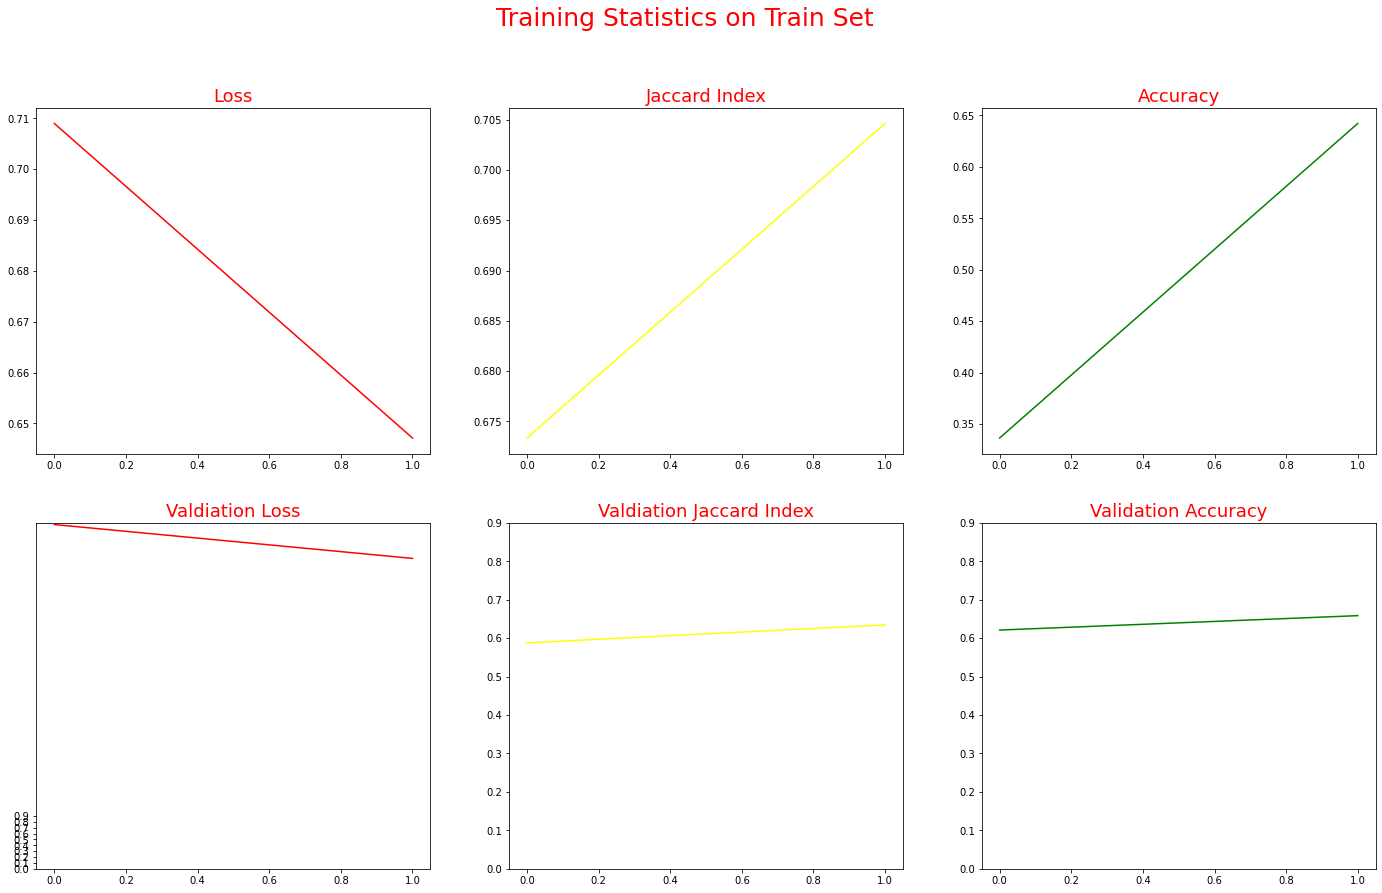

In [38]:
plt.figure(figsize=(24, 14))

plt.suptitle('Training Statistics on Train Set', fontsize = 25, color='red')

plt.subplot(2,3,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss',fontsize = 18, color='red')
plt.subplot(2,3,2)
plt.plot(hist.history['iou'], 'yellow')
plt.title('Jaccard Index',fontsize = 18, color='red')
plt.subplot(2,3,3)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy',fontsize = 18, color='red')

plt.subplot(2,3,4)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss',fontsize = 18, color='red')
plt.subplot(2,3,5)
plt.plot(hist.history['val_iou'], 'yellow')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Jaccard Index',fontsize = 18, color='red')
plt.subplot(2,3,6)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy',fontsize = 18, color='red')
plt.show()

### Visualising Predicted Lesions

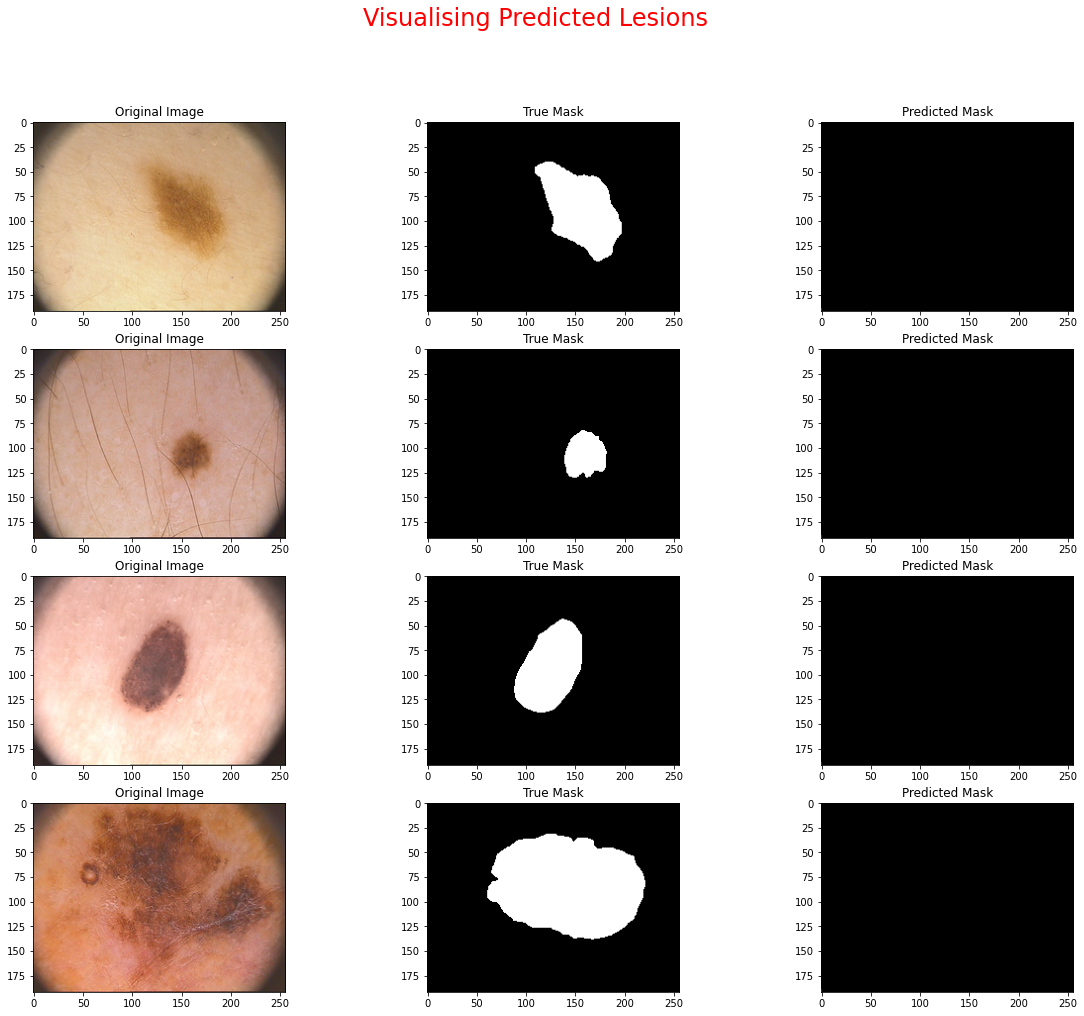

In [42]:
plt.figure(figsize=(20,16))

plt.suptitle('Visualising Predicted Lesions', fontsize = 24, color='red')

img_pred = model_1.predict(x_test[4].reshape(1,192,256,3))
plt.subplot(4,3,1)
plt.imshow(x_test[4])
plt.title('Original Image')
plt.subplot(4,3,2)
plt.imshow(y_test[4], plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Mask')

img_pred = model_1.predict(x_test[6].reshape(1,192,256,3))
plt.subplot(4,3,4)
plt.imshow(x_test[6])
plt.title('Original Image')
plt.subplot(4,3,5)
plt.imshow(y_test[6], plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,6)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Mask')

img_pred = model_1.predict(x_test[32].reshape(1,192,256,3))
plt.subplot(4,3,7)
plt.imshow(x_test[30])
plt.title('Original Image')
plt.subplot(4,3,8)
plt.imshow(y_test[30], plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,9)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Mask')

img_pred = model_1.predict(x_test[20].reshape(1,192,256,3))
plt.subplot(4,3,10)
plt.imshow(x_test[20])
plt.title('Original Image')
plt.subplot(4,3,11)
plt.imshow(y_test[21], plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,12)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Mask')

plt.show()

### Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5 .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values

In [40]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

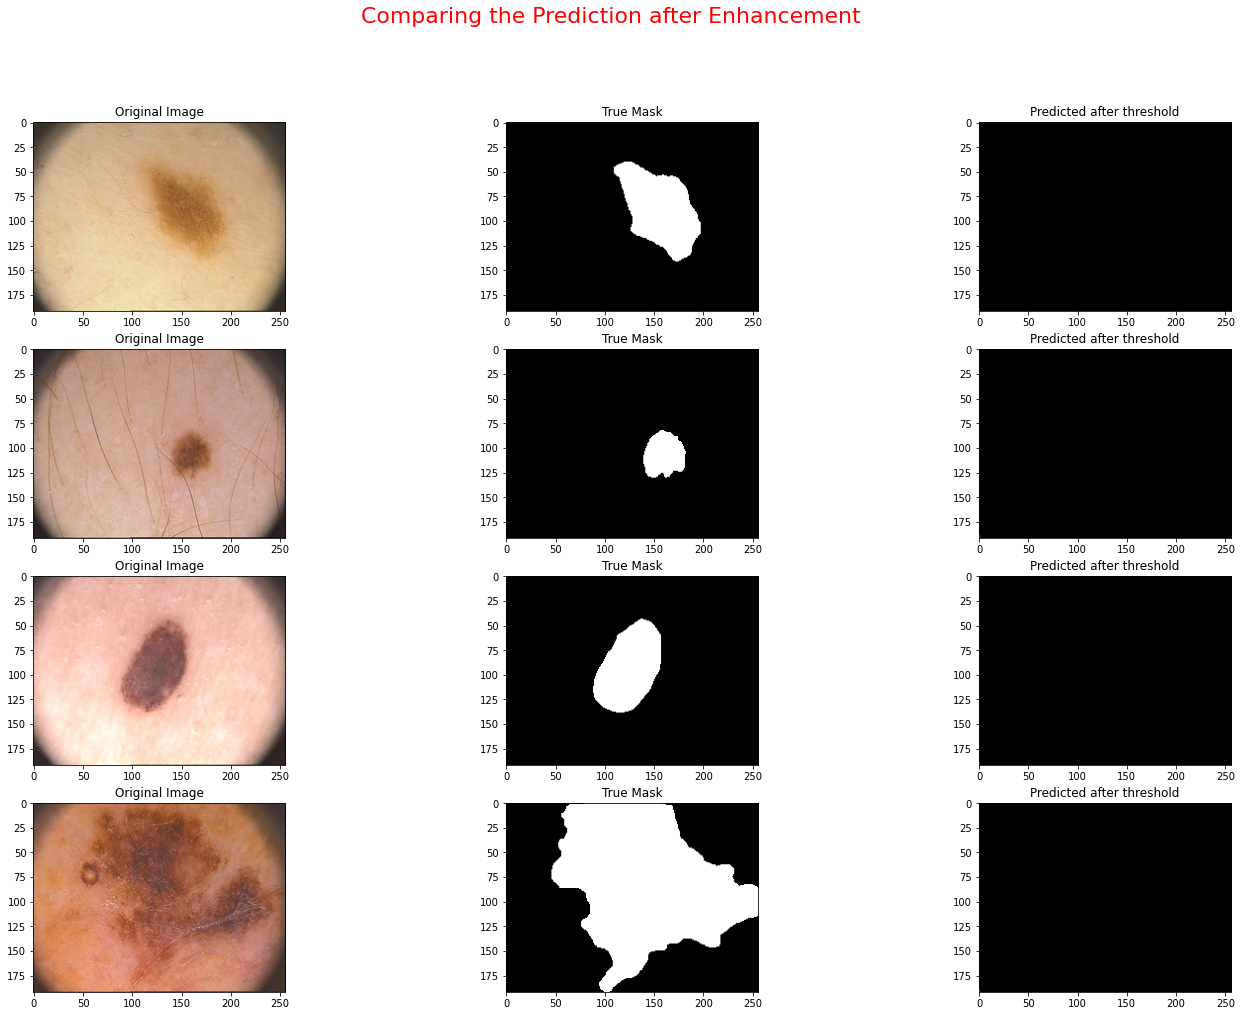

In [43]:
plt.figure(figsize=(24,16))

plt.suptitle('Comparing the Prediction after Enhancement', fontsize = 22, color='red')

plt.subplot(4,3,1)
plt.imshow(x_test[4])
plt.title('Original Image')
plt.subplot(4,3,2)
plt.imshow(y_test[4],plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,3)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted after threshold')

plt.subplot(4,3,4)
plt.imshow(x_test[6])
plt.title('Original Image')
plt.subplot(4,3,5)
plt.imshow(y_test[6],plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,6)
plt.imshow(enhance(x_test[19]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted after threshold')

plt.subplot(4,3,7)
plt.imshow(x_test[30])
plt.title('Original Image')
plt.subplot(4,3,8)
plt.imshow(y_test[30],plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,9)
plt.imshow(enhance(x_test[36]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted after threshold')


plt.subplot(4,3,10)
plt.imshow(x_test[20])
plt.title('Original Image')
plt.subplot(4,3,11)
plt.imshow(y_test[20],plt.cm.binary_r)
plt.title('True Mask')
plt.subplot(4,3,12)
plt.imshow(enhance(x_test[49]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted after threshold')

plt.show()